In [ ]:

from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
import tensorflow as tf
import torch 
import einops
import torchio as tio
import optax
from flax.training import train_state  
from torch.utils.data import DataLoader
import jax.profiler
import ml_collections
from ml_collections import config_dict
from functools import partial
import toolz
import chex    


In [ ]:



def filter_mask_of_intrest(masks,shift_x,shift_y):
  masks= jnp.round(masks)
  masks_a=(masks[:,:,0])==shift_x
  masks_b=(masks[:,:,1])==shift_y
  mask_0= jnp.logical_and(masks_a,masks_b).astype(int)    
  return mask_0




def get_new_mask_from_probs(mask_old,bi_chan_probs,dim_stride,mask_shape,mask_shape_end,rearrange_to_intertwine_einops ):
    """ 
    given bi channel probs where first channel will be interpreted as probability of being the same id (1 or 0)
    as the sv backward the axis; and second channel probability of being the same supervoxel forward the axis 
    """
    #we add 1 becouse of batch
    dim_stride_curr=dim_stride+1
    #we get propositions forward and backward od old mask
    old_forward=jnp.take(mask_old, indices=jnp.arange(1,mask_shape[dim_stride_curr]),axis=dim_stride_curr )
    old_back =jnp.take(mask_old, indices=jnp.arange(0,mask_shape[dim_stride_curr]),axis=dim_stride_curr )
    #in order to get correct shape we need to add zeros to forward
    to_end_grid=jnp.ones(mask_shape_end)
    old_forward= jnp.concatenate((old_forward,to_end_grid) ,axis= dim_stride_curr)

    
    old_propositions=jnp.stack([old_forward,old_back],axis=-1)# w h n_dim 2
    #chosen values and its alternative
    bi_chan_probs=jnp.round(bi_chan_probs)# TODO change into diff round - this is non differentiable !!   

    bi_chan_probs=einops.repeat(bi_chan_probs,'w h pr->w h d pr',d=2)

    chosen_values=jnp.multiply(old_propositions,bi_chan_probs)
    chosen_values= jnp.sum(chosen_values,axis=-1)
    chosen_values_alt=jnp.multiply(old_propositions,(jnp.flip(bi_chan_probs,axis=-1)))
    chosen_values_alt= jnp.sum(chosen_values_alt,axis=-1)

    
    mask_combined=einops.rearrange([chosen_values,mask_old],rearrange_to_intertwine_einops) 
    mask_combined_alt=einops.rearrange([chosen_values_alt,mask_old],rearrange_to_intertwine_einops)

    shift_x=0
    shift_y=0
    mask_combined_print=filter_mask_of_intrest(jnp.round(mask_combined[0,:,:,:]),shift_x,shift_y)
    mask_old_print=filter_mask_of_intrest(jnp.round(mask_old[0,:,:,:]),shift_x,shift_y)
    chosen_values_print=filter_mask_of_intrest(jnp.round(chosen_values[0,:,:,:]),shift_x,shift_y)
    # jax.debug.print("{y} {z} \n mask_combined_print \n {a} \n mask_old_print \n{b} \n chosen_values_print \n {c} \n *****************", a=mask_combined_print ,b=mask_old_print, c=chosen_values_print ,y=shift_x, z= shift_y)

    return mask_combined,mask_combined_alt
dim_stride=0
rearrange_to_intertwine_einops='f h w cc-> (h f) w cc'

get_new_mask_from_probs(mask_old,bi_chan_probs,dim_stride,mask_shape,mask_shape_end,rearrange_to_intertwine_einops )

In [ ]:
def harder_diff_round(a):
    return jnp.round(a)

def differentiable_eq(a:float,b:float):
    """
    will give big value if a anb b are similar and small otherwise
    bot a and b are assumed to be between 0 and 1
    """
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b+(1-a)*(1-b)
    return harder_diff_round(res)

def differentiable_and(a:float,b:float):
    """
    will give big value if a anb b are similar and small otherwise
    bot a and b are assumed to be between 0 and 1
    """
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b
    return harder_diff_round(res)



#versions with second entry keeping as int
v_differentiable_eq=jax.vmap(differentiable_eq,in_axes=(0,None))
v_v_differentiable_eq=jax.vmap(v_differentiable_eq,in_axes=(0,None))
v_v_v_differentiable_eq=jax.vmap(v_v_differentiable_eq,in_axes=(0,None))

#version where both entries are 3 dimensional
v_differentiable_eq_bi=jax.vmap(differentiable_eq,in_axes=(0,0))
v_v_differentiable_eq_bi=jax.vmap(v_differentiable_eq_bi,in_axes=(0,0))
v_v_v_differentiable_eq_bi=jax.vmap(v_v_differentiable_eq_bi,in_axes=(0,0))

def filter_mask_of_intrest(mask,shift_x,shift_y):
    """
    filters the mask to set to 1 only if it is this that we are currently intressted in 

    """
    coor_0_agree=v_v_differentiable_eq(mask[:,:,0],shift_x)
    coor_1_agree=v_v_differentiable_eq(mask[:,:,1],shift_y)
    print(f"coor_0_agree {coor_0_agree} coor_1_agree {coor_1_agree} ")
    return differentiable_and(coor_0_agree,coor_1_agree)  
  
dummy_mask=jnp.array([[[0.0,0.0],[0.0,1.0],[1.0,0.0],[1.0,1.0]]])

filter_mask_of_intrest(dummy_mask, 0,1 )

In [ ]:
v_v_differentiable_eq_bi(jnp.array([[0.,0.,1.,1.]]),jnp.array([[1.,0.,1.,0.]]))

In [ ]:
def get_diameter_no_pad(r):
    """
    so every time we have n elements we can get n+ more elements
    so analyzing on single axis
    start from 1 ->1+1+1 =3 good
    start from 3 ->3+3+1=7 good 
    start from 7 ->7+7+1=15 good 
    """
    curr = 1
    for i in range(0,r):
        curr=curr*2+1
    return curr

def get_diameter(r):
    return get_diameter_no_pad(r)+1

get_diameter(3)

In [ ]:
import pandas as pd
def get_initial_supervoxel_masks(orig_grid_shape,shift_x,shift_y):
    """
    on the basis of the present shifts we will initialize the masks
    ids of the supervoxels here are implicit based on which mask and what location we are talking about
    """
    initt=np.zeros(orig_grid_shape)
    initt[shift_x::2,shift_y::2,0]=shift_x
    initt[shift_x::2,shift_y::2,1]=shift_y

    initt[shift_x::2,shift_y::4,2]=1
    initt[shift_x::4,shift_y::2,3]=1

    return initt

def disp_to_pandas(probs,shappe ):
    probs_to_disp= einops.rearrange(probs,'w h c-> (w h) c')
    probs_to_disp=np.round(probs_to_disp,1)
    # probs_to_disp=list(map(lambda twoo: f"{twoo[0]} {twoo[1]}",list(probs_to_disp)))
    probs_to_disp=np.array(probs_to_disp)
    probs_to_disp=list(map(lambda twoo: " ".join(list(map(str,twoo))),list(probs_to_disp)))
    probs_to_disp=np.array(probs_to_disp).reshape(shappe)
    return pd.DataFrame(probs_to_disp)

def disp_to_pandas_curr_shape(probs ):
    return disp_to_pandas(probs,(probs.shape[0],probs.shape[1]) )


cfg = config_dict.ConfigDict()
cfg.total_steps=3
cfg.batch_size=1
# cfg.learning_rate=0.00002 #used for warmup with average coverage loss
cfg.learning_rate=0.0001
cfg.num_dim=4
cfg.batch_size_pmapped=np.max([cfg.batch_size//jax.local_device_count(),1])
cfg.img_size = (cfg.batch_size,1,64,64)
# cfg.label_size = (cfg.batch_size,32,32)
cfg.r_x_total= 3
cfg.r_y_total= 3
cfg.orig_grid_shape= (cfg.img_size[2]//2**cfg.r_x_total,cfg.img_size[3]//2**cfg.r_y_total,cfg.num_dim)
cfg.epsilon=0.0000000001 
cfg = ml_collections.FrozenConfigDict(cfg)

initial_masks= jnp.stack([
            get_initial_supervoxel_masks(cfg.orig_grid_shape,0,0),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,1,0),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,0,1),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,1,1)
                ],axis=0)
initial_masks=jnp.sum(initial_masks,axis=0).astype(int) 
disp_to_pandas_curr_shape(initial_masks)


In [ ]:
def masks_binary(masks,shift_x,shift_y,n_2,n_3):
    masks_a=(masks[0,:,:,0])==shift_x
    masks_b=(masks[0,:,:,1])==shift_y
    masks_c=(masks[0,:,:,2])==n_2
    masks_d=(masks[0,:,:,3])==n_3
    mask_0_a= jnp.logical_and(masks_a,masks_b)   
    mask_0_b= jnp.logical_and(masks_c,masks_d)
    mask_0= jnp.logical_and(mask_0_a,mask_0_b)
    return mask_0.astype(int) 


def get_summed_num_mask(masks_bin):
    masks_bin=jnp.round(masks_bin)
    res=(
                 masks_binary(masks_bin,0,0,0,0)
                +masks_binary(masks_bin,1,0,0,0)*2 
                +masks_binary(masks_bin,0,1,0,0)*3 
                +masks_binary(masks_bin,1,1,0,0)*4 
                
                +masks_binary(masks_bin,0,0,1,0)*5
                +masks_binary(masks_bin,0,1,1,0)*6
                +masks_binary(masks_bin,1,0,1,0)*7
                +masks_binary(masks_bin,1,1,1,0)*8  
                
                +masks_binary(masks_bin,0,0,0,1)*9
                +masks_binary(masks_bin,0,1,0,1)*10
                +masks_binary(masks_bin,1,0,0,1)*11
                +masks_binary(masks_bin,1,1,0,1)*12
                
                +masks_binary(masks_bin,0,0,1,1)*13
                +masks_binary(masks_bin,0,1,1,1)*14
                +masks_binary(masks_bin,1,0,1,1)*15
                +masks_binary(masks_bin,1,1,1,1)*16)
    return res
    
print(disp_to_pandas_curr_shape(initial_masks))
print(get_summed_num_mask(einops.rearrange(initial_masks,'w h c-> 1 w h c')))


In [ ]:
def harder_diff_round(a):
    return jnp.round(a)

def differentiable_eq(a:float,b:float):
    """
    will give big value if a anb b are similar and small otherwise
    bot a and b are assumed to be between 0 and 1
    """
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b+(1-a)*(1-b)
    return harder_diff_round(res)

def differentiable_and(a:float,b:float):
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b
    return harder_diff_round(res)

def filter_mask_of_intrest(mask,shift_x,shift_y):
    """
    filters the mask to set to 1 only if it is this that we are currently intressted in 
    """
    coor_0_agree=v_v_differentiable_eq(mask[:,:,0],shift_x)
    coor_1_agree=v_v_differentiable_eq(mask[:,:,1],shift_y)

    # coor_0_agree=v_v_differentiable_eq(mask[:,:,0],shift_x)
    # coor_1_agree=v_v_differentiable_eq(mask[:,:,1],shift_y)

    return differentiable_and(coor_0_agree,coor_1_agree)    

In [ ]:
import jax
import jax.numpy as jnp

def a(x):
    return jnp.sin(x*(jnp.pi/2))*jnp.sin(x*(jnp.pi/2))

x = jnp.float32(1.0)

print(jax.make_jaxpr(a)(x))
# { lambda ; a:f32[]. let b:f32[] = sin a in (b,) }

print(jax.make_jaxpr(jax.grad(a))(x))
# { lambda ; a:f32[]. let
#     _:f32[] = sin a
#     b:f32[] = cos a
#     c:f32[] = mul 1.0 b
#   in (c,) }

In [ ]:

def diff_round(x):
    """
    differentiable version of round function
    """
    # return x - jnp.sin(2*jnp.pi*x)/(2*jnp.pi)
    # return jnp.sin(x*(jnp.pi/2))**2
    return jnp.sin(x*(jnp.pi/2))*jnp.sin(x*(jnp.pi/2))

def harder_diff_round(x):
    return diff_round(diff_round(x))

def differentiable_eq(a:float,b:float):
    """
    will give big value if a anb b are similar and small otherwise
    bot a and b are assumed to be between 0 and 1
    """
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b+(1-a)*(1-b)
    return harder_diff_round(res)

def differentiable_and(a:float,b:float):
    a= diff_round(a)
    b= diff_round(b)
    res=a*b
    return res

#versions with second entry keeping as int
v_differentiable_eq=jax.vmap(differentiable_eq,in_axes=(0,None))
v_v_differentiable_eq=jax.vmap(v_differentiable_eq,in_axes=(0,None))
v_v_v_differentiable_eq=jax.vmap(v_v_differentiable_eq,in_axes=(0,None))

def filter_mask_of_intrest(mask,initial_mask_id): #krowa test filter_mask_of_intrest
    """
    filters the mask to set to 1 only if it is this that we are currently intressted in 
    """
    coor_0_agree=v_v_differentiable_eq(mask[:,:,0],initial_mask_id[0])
    coor_1_agree=v_v_differentiable_eq(mask[:,:,1],initial_mask_id[1])
    coor_2_agree=v_v_differentiable_eq(mask[:,:,2],initial_mask_id[2])
    coor_3_agree=v_v_differentiable_eq(mask[:,:,3],initial_mask_id[3])
    a=differentiable_and(coor_0_agree,coor_1_agree)
    b=differentiable_and(coor_2_agree,coor_3_agree) 

    # coor_0_agree=v_v_differentiable_eq(mask[:,:,0],shift_x)
    # coor_1_agree=v_v_differentiable_eq(mask[:,:,1],shift_y)

    return differentiable_and(a,b)        

mask=jnp.array([[[0.,0.,0.,0.],[1.,0.,0.,0.],[0.,1.,0.,0.],[1.,1.,0.,0.]
                ,[0.,0.,1.,0.],[1.,0.,1.,0.],[0.,1.,1.,0.],[1.,1.,1.,0.]
                ,[0.,0.,0.,1.],[1.,0.,0.,1.],[0.,1.,0.,1.],[1.,1.,0.,1.]
                ,[0.,0.,1.,1.],[1.,0.,1.,1.],[0.,1.,1.,1.],[1.,1.,1.,1.]
                  ]])

shapp=mask.shape
print(shapp)
for i in range(shapp[1]):
    print(filter_mask_of_intrest(mask, mask[0,i,:]))

In [ ]:
from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_2D import SpixelNet
from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_utils_2D import *
from super_voxels.SIN.SIN_jax_2D_simpler.shape_reshape_functions import *
from testUtils.spleenTest import get_spleen_data
import h5py
f = h5py.File('/workspaces/Jax_cuda_med/data/hdf5_loc/example_mask.hdf5', 'r+')
masks=f['masks'][:,:,:]
f.close()
cached_subj =get_spleen_data()[0]
masks= einops.rearrange(masks,'w h c->1 w h c')
masks.shape


In [ ]:
image=cached_subj[0][0,:,64:-64,64:-64,32:33]
image.shape

In [10]:
from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_2D import SpixelNet
from super_voxels.SIN.SIN_jax_2D_simpler.model_sin_jax_utils_2D import *
from super_voxels.SIN.SIN_jax_2D_simpler.shape_reshape_functions import *
from testUtils.spleenTest import get_spleen_data
import h5py

from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
import tensorflow as tf
import torch 
import einops
import torchio as tio
import optax
from flax.training import train_state  
from torch.utils.data import DataLoader
import jax.profiler
import ml_collections
from ml_collections import config_dict
from functools import partial
import toolz
import chex   
f = h5py.File('/workspaces/Jax_cuda_med/data/hdf5_loc/example_mask.hdf5', 'r+')
masks=f['masks'][:,:,:]
f.close()
cached_subj =get_spleen_data()[0]
masks= einops.rearrange(masks,'w h c->1 w h c')
masks.shape



slicee=15
image=cached_subj[0][0,0,64:-64,64:-64,slicee]
image= einops.rearrange(image,'w h->1 w h 1')

image.shape

cfg = config_dict.ConfigDict()
cfg.total_steps=300
# cfg.learning_rate=0.00002 #used for warmup with average coverage loss
cfg.learning_rate=0.0000001

cfg.num_dim=4
cfg.batch_size=160

cfg.batch_size_pmapped=np.max([cfg.batch_size//jax.local_device_count(),1])
cfg.img_size = (cfg.batch_size,1,256,256)
cfg.label_size = (cfg.batch_size,256,256)
cfg.r_x_total= 3
cfg.r_y_total= 3
cfg.orig_grid_shape= (cfg.img_size[2]//2**cfg.r_x_total,cfg.img_size[3]//2**cfg.r_y_total,cfg.num_dim)
cfg.masks_num= 4# number of mask (4 in 2D and 8 in 3D)

##getting the importance of the losses associated with deconvolutions
## generally last one is most similar to the actual image - hence should be most important
cfg.deconves_importances=(0.1,0.5,1.0)
#some constant multipliers related to the fact that those losses are disproportionally smaller than the other ones
cfg.edge_loss_multiplier=10.0
cfg.feature_loss_multiplier=10.0
#just for numerical stability
cfg.epsilon=0.0000000001 
cfg = ml_collections.FrozenConfigDict(cfg)
dynamic_cfg_a = config_dict.ConfigDict()
dynamic_cfg_a.is_beg=False
dynamic_cfg_a = ml_collections.config_dict.FrozenConfigDict(dynamic_cfg_a)


prng = jax.random.PRNGKey(42)
dim_stride=0
r_x=3
r_y=3
rearrange_to_intertwine_einops='f bb h w cc->bb (h f) w cc'
translation_val=4
features=32
initial_masks= jnp.stack([
            get_initial_supervoxel_masks(cfg.orig_grid_shape,0,0),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,1,0),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,0,1),
            get_initial_supervoxel_masks(cfg.orig_grid_shape,1,1)
                ],axis=0)
initial_masks= jnp.sum(initial_masks,axis=0)
initial_masks=einops.rearrange(initial_masks, 'a b c ->1 a b c')

resized_image=image
curried=(resized_image,masks,masks,initial_masks,masks,resized_image,initial_masks)


model = De_conv_batched_for_scan(cfg,dynamic_cfg_a,dim_stride,r_x, r_y,rearrange_to_intertwine_einops,translation_val,features )
params = model.init({'params': prng}, curried,0)#['params']
new_curried,losses=model.apply(params, curried,0)
resized_image,mask_combined,mask_combined_alt,initial_masks,mask_combined_new,resized_image_new,initial_masks_new=new_curried

print(losses.shape)
print(mask_combined_new.shape)
print(resized_image_new.shape)
print(initial_masks_new.shape)

data loaded from hdf5
(1, 256)
(1, 256, 16, 16, 4)
(1, 256, 16, 16, 1)
(1, 256, 4)


In [1]:
#based on https://github.com/yuanqqq/SIN
from flax import linen as nn
import numpy as np
from typing import Any, Callable, Optional, Tuple, Type, List
from jax import lax, random, numpy as jnp
import einops
import torchio
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
import jax
import tensorflow as tf
import torch 
import einops
import torchio as tio
import optax
from flax.training import train_state  
from torch.utils.data import DataLoader
import jax.profiler
import ml_collections
from ml_collections import config_dict
from functools import partial
import toolz
import chex
from .render2D import diff_round,Conv_trio
import jax.scipy as jsp
from flax.linen import partitioning as nn_partitioning
from  .shape_reshape_functions import *
remat = nn_partitioning.remat

class De_conv_not_sym(nn.Module):
    """
    Deconvolution plus activation function
    strides may benon symmetric - and is controlled by dim_stride
    dim_stride indicates which dimension should have stride =2
    if dim_stride is -1 all dimension should be 2
    """
    cfg: ml_collections.config_dict.config_dict.ConfigDict
    features: int
    dim_stride:int

    def setup(self):
        strides=[1,1]  
        if(self.dim_stride==-1):
            strides=[2,2]
        strides[self.dim_stride]=2 
        strides=tuple(strides)           
        self.convv = nn.ConvTranspose(
                features=self.features,
                kernel_size=(5, 5),
                strides=strides,              
                )

    @nn.compact
    def __call__(self, x: jnp.ndarray) -> jnp.ndarray:
        x=self.convv(x)
        return jax.nn.gelu(x)
    
def harder_diff_round(x):
    # return diff_round(diff_round(x))
    return diff_round(diff_round(x))

    # return diff_round(diff_round(x))
    # return  diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(diff_round(x)))))))))))))
    # - 0.51 so all 
    # return diff_round(diff_round(nn.relu(x-0.51)))
    # return nn.softmax(jnp.power((x)+1,14))

v_harder_diff_round=jax.vmap(harder_diff_round)
v_v_harder_diff_round=jax.vmap(v_harder_diff_round)
v_v_v_harder_diff_round=jax.vmap(v_v_harder_diff_round)

    
def masked_cross_entropy_loss(logits: jnp.ndarray,
                       one_hot_labels: jnp.ndarray,
                       mask: Optional[jnp.ndarray] = None) -> jnp.ndarray:
  """
  based on https://github.com/google-research/sam/blob/main/sam_jax/training_utils/flax_training.py
  Returns the cross entropy loss between some logits and some labels.
  Args:
    logits: Output of the model.
    one_hot_labels: One-hot encoded labels. Dimensions should match the logits.
    mask: Mask to apply to the loss to ignore some samples (usually, the padding
      of the batch). Array of ones and zeros.
  Returns:
    The cross entropy, averaged over the first dimension (samples).
  """
  log_softmax_logits = jax.nn.log_softmax(logits)
#   mask = mask.reshape([logits.shape[0], 1])
  loss = -jnp.sum(one_hot_labels * log_softmax_logits * mask) / mask.sum()
  return jnp.nan_to_num(loss)  # Set to zero if there is no non-masked samples.    

def losss(prob_plane,label_plane):
    """
    we will compare each plane in the axis the we did strided deconvolution
    as is important we have two channels here
    one channel will be interpreted as the probability that the voxel up the axis is the same class
    other channels will look for the same down axis

    than we need to compare it to the same information in the label - gold standard
    however ignoring all of the spots where label is 0 - not all voxels needs to be segmented in gold standard
    prob_plane - 2 channel planes with probability up and down
    label_plane - 2 channel float plane about gold standard - first channel tell is voxel the same class 
        as up in axis , second down  
    """
    
    return masked_cross_entropy_loss(nn.sigmoid(prob_plane),label_plane,label_plane)
    # return optax.sigmoid_binary_cross_entropy(prob_plane, label_plane)
@partial(jax.profiler.annotate_function, name="check_mask_consistency")
def check_mask_consistency(mask_old,mask_new,axis,epsilon):
    """
    as we are simulating interpolation we want to check weather the new mask behaves as
    the interpolation of old one - so the new entries of the mask should be similar to the entries up ro down axis 
    so basically we want to get a similar values when we go 1 up and one down the axis
    However we have the special case of the edge, 
    in order to detect the edge and treat it separately we will use image gradients in a given direction
    """
    mutliplier=3
    #we pad becouse on the border we have high gradient - and we want to ignore it
    old_mask_padded= jnp.pad(mask_old,((1,1),(1,1)))
    #as some entries will be negative oter positive we square it
    grad = jnp.power(jnp.gradient(old_mask_padded,axis=axis),2)
    #removing unnecessery padding
    grad= grad[1:-1,1:-1]
    #we multiply to make sure that we will get values above 1 - we will relu later so exact values do not matter
    #we have here the old mask dilatated in place of edges in a chosen axis
    sum_grads= grad*mutliplier+mask_old*mutliplier
    #now we subtract from the new mask old one so all positive value that remain are in the spots 
    #that should not be present
    for_loss=mask_new-sum_grads
    #we get rid of negative values - as those should not contribute to loss
    # for_loss=jnp.exp(for_loss)
    for_loss=jnp.power(2,for_loss)
    # for_loss=nn.relu(for_loss)
    #we sum all of the positive entries - the bigger the sum the worse is the consistency
    # now we need also to get in opposite side so we assume shrinking instead of enlarging and check weather a new version agrees with a shrinked version ...
    #so only positive should be shrinken version of old mask
    diff_grads= mask_old-grad*mutliplier
    # diff_grads=jnp.exp(diff_grads)
    diff_grads=jnp.power(2,diff_grads)
    # diff_grads=nn.relu(diff_grads)
    #now we want to make sure that where diff grads are big the new mask is also
    should_be_high= jnp.multiply(diff_grads,mask_new)
    
    should_low=jnp.mean(for_loss.flatten())+epsilon
    should_high=jnp.mean(should_be_high.flatten())+epsilon

    return should_high/(should_high+should_low)


def translate_mask_in_axis(mask:jnp.ndarray, axis:int,is_forward:int,translation_val:int,mask_shape:Tuple[int]):
    """
    translates the mask in a given axis 
    also forward or backward it perform it by padding and
    take
    value of translation is described by translation_val
    """
    mask_orig=mask.copy()
    mask= jnp.take(mask, indices=jnp.arange(translation_val*(1-is_forward),mask_shape[axis]-translation_val* is_forward),axis=axis )
    to_pad=np.array([[0,0],[0,0]])
    is_back=1-is_forward
    to_pad[axis,is_back]=translation_val

    mask= jnp.pad(mask,to_pad)
    return jnp.multiply(mask,mask_orig)

def get_image_features(image:jnp.ndarray,mask:jnp.ndarray,epsilon:float):
    """
    given image and a mask will calculate the set of image features
    that will return as a vector  
    """
    masked_image= jnp.multiply(image,mask)
    meann= jnp.sum(masked_image.flatten())/(jnp.sum(mask.flatten())+epsilon)
    varr= jnp.power( jnp.multiply((masked_image-meann),mask  ),2)
    varr=jnp.sum(varr.flatten())/(jnp.sum(mask.flatten())+epsilon)
    return jnp.array([meann, varr])

def get_translated_mask_variance(image:jnp.ndarray
                                 ,mask:jnp.ndarray
                                 ,translation_val:int
                                 ,mask_shape:Tuple[int]
                                 ,feature_loss_multiplier:float
                                 ,epsilon:float):
    """ 
    we will make a translation of the mask in all directions and check wether image features change
    generally the same supervoxel should have the same image features in all of its subregions
    so we want the variance here to be small 
    """
    image=einops.rearrange(image,'w h c-> w (h c)')
    features=jnp.stack([
        get_image_features(image,translate_mask_in_axis(mask,0,0,translation_val,mask_shape),epsilon),
        get_image_features(image,translate_mask_in_axis(mask,0,1,translation_val,mask_shape),epsilon),
        get_image_features(image,translate_mask_in_axis(mask,1,0,translation_val,mask_shape),epsilon),
        get_image_features(image,translate_mask_in_axis(mask,1,1,translation_val,mask_shape),epsilon)
              ])
    # maxes= jnp.max(features,axis=0)
    # features=features/maxes
    feature_variance=jnp.var(features,axis=0)*feature_loss_multiplier
    return jnp.mean(feature_variance)
    # return jnp.var(jnp.multiply(image,mask).flatten())


@partial(jax.profiler.annotate_function, name="get_edgeloss")
def get_edgeloss(image:jnp.ndarray,mask:jnp.ndarray,axis:int,edge_loss_multiplier:float):
    """
    in order to also force the supervoxels to keep to the strong edges
    we can add edge loss that will be comparing a directional gradient of the mask
    and image, hovewer the importance of the loss should be proportional to the strength of the edges
    so we can simply get first the l2 loss element wise than scale it by the image gradient
    """
    image_gradient=jnp.gradient(image,axis=axis)#*edge_loss_multiplier
    mask_gradient=jnp.gradient(mask,axis=axis)#*edge_loss_multiplier
    # image_gradient=image_gradient/jnp.max(image_gradient.flatten())
    # mask_gradient=mask_gradient/jnp.max(mask_gradient.flatten())

    element_wise_l2=optax.l2_loss(image_gradient,mask_gradient)
    # element_wise_l2= jnp.multiply(element_wise_l2,image_gradient)*edge_loss_multiplier
    return jnp.mean(element_wise_l2.flatten())*(-1)

def rounding_loss(arr):
    """
    it is minimized when all entries are either 0 or 1
    """
    return 1.00000001-jnp.mean(jnp.power(arr-(1-arr),2) )

def differentiable_eq(a:float,b:float):
    """
    will give big value if a anb b are similar and small otherwise
    bot a and b are assumed to be between 0 and 1
    """
    a= harder_diff_round(a)
    b= harder_diff_round(b)
    res=a*b+(1-a)*(1-b)
    return harder_diff_round(res)

def differentiable_and(a:float,b:float):
    a= diff_round(a)
    b= diff_round(b)
    res=a*b
    return res

#versions with second entry keeping as int
v_differentiable_eq=jax.vmap(differentiable_eq,in_axes=(0,None))
v_v_differentiable_eq=jax.vmap(v_differentiable_eq,in_axes=(0,None))
v_v_v_differentiable_eq=jax.vmap(v_v_differentiable_eq,in_axes=(0,None))

#version where both entries are 3 dimensional
v_differentiable_and_bi=jax.vmap(differentiable_and,in_axes=(0,0))
v_v_differentiable_and_bi=jax.vmap(v_differentiable_and_bi,in_axes=(0,0))
v_v_v_differentiable_and_bi=jax.vmap(v_v_differentiable_and_bi,in_axes=(0,0))


def filter_mask_of_intrest(mask,initial_mask_id): 
    """
    filters the mask to set to 1 only if it is this that we are currently intressted in 
    """
    coor_0_agree=v_v_differentiable_eq(mask[:,:,0],initial_mask_id[0])
    coor_1_agree=v_v_differentiable_eq(mask[:,:,1],initial_mask_id[1])
    coor_2_agree=v_v_differentiable_eq(mask[:,:,2],initial_mask_id[2])
    coor_3_agree=v_v_differentiable_eq(mask[:,:,3],initial_mask_id[3])
    a=differentiable_and(coor_0_agree,coor_1_agree)
    b=differentiable_and(coor_2_agree,coor_3_agree) 

    # coor_0_agree=v_v_differentiable_eq(mask[:,:,0],shift_x)
    # coor_1_agree=v_v_differentiable_eq(mask[:,:,1],shift_y)

    return differentiable_and(a,b)        


class Apply_on_single_area(nn.Module):
    """
    module will be vmapped or scanned over all supervoxel areas
    for simplicity of implementation here we are just working on single supervoxel area
    """
    cfg: ml_collections.config_dict.config_dict.ConfigDict
    dynamic_cfg: ml_collections.config_dict.config_dict.ConfigDict
    rearrange_to_intertwine_einops:str
    dim_stride:int
    curr_shape:Tuple[int]
    deconved_shape:Tuple[int]
    translation_val:int
    diameter_x:int
    diameter_y:int
    diameter_x_curr:int
    diameter_y_curr:int
    p_x:int
    p_y:int
    to_reshape_back_x:int
    to_reshape_back_y:int    
    def setup(self):
        self.mask_shape=(self.diameter_x_curr,self.diameter_y_curr,self.cfg.num_dim)        
        mask_shape_list=list(self.mask_shape)
        mask_shape_list[self.dim_stride]=1
        self.mask_shape_end=tuple(mask_shape_list)


    # @partial(jax.profiler.annotate_function, name="select_set_non_overlapping_regions")
    # def select_set_non_overlapping_regions(self,index):
    #     """
    #     in order are for shift_x,shift_y
    #     0) 0 0
    #     1) 1 0
    #     2) 0 1
    #     3) 1 1
    #     """        
    #     def fun_ff():
    #         return set_non_overlapping_regions(self.diameter_x,self.diameter_y,0,0,self.p_x,self.p_y)
            
    #     def fun_tf():
    #         return set_non_overlapping_regions(self.diameter_x,self.diameter_y,1,0,self.p_x,self.p_y)
            
    #     def fun_ft():
    #         return set_non_overlapping_regions(self.diameter_x,self.diameter_y,0,1,self.p_x,self.p_y)

    #     def fun_tt():
    #         return set_non_overlapping_regions(self.diameter_x,self.diameter_y,1,1,self.p_x,self.p_y)

    #     functions_list=[fun_ff,fun_tf,fun_ft,fun_tt]
    #     return jax.lax.switch(index,functions_list)






    def get_feature_var_loss(self,resized_image,mask_combined,mask_combined_alt,epsilon, initial_mask_id):
        mask_combined_curr=filter_mask_of_intrest(mask_combined_alt,initial_mask_id)

        #using alternative mask - that should be worse then main version
        feature_variance_loss_alt=get_translated_mask_variance(resized_image, mask_combined_curr
                                                        ,self.translation_val, (self.diameter_x,
                                                                                self.diameter_y ) ,self.cfg.feature_loss_multiplier,self.cfg.epsilon)


        #using main mask
        mask_combined_curr=filter_mask_of_intrest(mask_combined,initial_mask_id)

        feature_variance_loss_main=get_translated_mask_variance(resized_image, mask_combined_curr
                                                        ,self.translation_val, (self.diameter_x,
                                                                                self.diameter_y ) ,self.cfg.feature_loss_multiplier,self.cfg.epsilon )
         #feature_variance_loss_main should be small becouse we want to minimize the variance of features in chosen supervoxel
        #feature_variance_loss_alt should be big

        #such calculation will lead to be in range 0-1
        feature_variance_loss=feature_variance_loss_main/((feature_variance_loss_main+feature_variance_loss_alt) +epsilon)



        # return feature_variance_loss krowa TODO(unhash)
        return feature_variance_loss_main



    @nn.compact
    def __call__(self
                 ,resized_image:jnp.ndarray
                ,mask_combined:jnp.ndarray
                ,mask_combined_alt:jnp.ndarray
                ,mask_index:int
                 ,initial_mask_id:jnp.ndarray ) -> jnp.ndarray:

        #calculate image feature variance in the supervoxel itself
        # feature_variance_loss,edgeloss,mask_combined=self.get_feature_va_and_edge_loss(resized_image,chosen_values,chosen_values_alt,mask_old,self.cfg.epsilon)
        
        # mask_combined=mask_combined.at[:,-1].set(0) 
        # mask_combined=mask_combined.at[-1,:].set(0)        
        # shift_x= jnp.remainder(mask_index,2)
        # shift_y=mask_index//2
        # mask_combined_print=filter_mask_of_intrest(jnp.round(mask_combined),shift_x,shift_y)*(mask_index+1)+((area_index+1)*100)

        return self.get_feature_var_loss(resized_image,mask_combined,mask_combined_alt,self.cfg.epsilon,initial_mask_id)


v_Apply_on_single_area=nn.vmap(Apply_on_single_area
                            ,in_axes=(0, 0,0,None,0)
                            ,out_axes=0
                            ,variable_axes={'params': None} #parametters are shared
                            ,split_rngs={'params': False}
                            )

batched_v_Apply_on_single_area=nn.vmap(v_Apply_on_single_area
                            ,in_axes=(0, 0,0,None,0)
                            ,out_axes=0
                            ,variable_axes={'params': None} #parametters are shared
                            ,split_rngs={'params': False}
                            )

v_image_resize=jax.vmap(jax.image.resize,in_axes=(0,None,None))

def masks_binary(masks,shift_x,shift_y,n_2,n_3):
    masks_a=(masks[0,:,:,0])==shift_x
    masks_b=(masks[0,:,:,1])==shift_y
    masks_c=(masks[0,:,:,2])==n_2
    masks_d=(masks[0,:,:,3])==n_3
    mask_0_a= jnp.logical_and(masks_a,masks_b)   
    mask_0_b= jnp.logical_and(masks_c,masks_d)
    mask_0= jnp.logical_and(mask_0_a,mask_0_b)
    return mask_0.astype(int) 


def get_summed_num_mask(masks_bin):
    masks_bin=jnp.round(masks_bin)
    res=(
                 masks_binary(masks_bin,0,0,0,0)
                +masks_binary(masks_bin,1,0,0,0)*2 
                +masks_binary(masks_bin,0,1,0,0)*3 
                +masks_binary(masks_bin,1,1,0,0)*4 
                
                +masks_binary(masks_bin,0,0,1,0)*5
                +masks_binary(masks_bin,0,1,1,0)*6
                +masks_binary(masks_bin,1,0,1,0)*7
                +masks_binary(masks_bin,1,1,1,0)*8  
                
                +masks_binary(masks_bin,0,0,0,1)*9
                +masks_binary(masks_bin,0,1,0,1)*10
                +masks_binary(masks_bin,1,0,0,1)*11
                +masks_binary(masks_bin,1,1,0,1)*12
                
                +masks_binary(masks_bin,0,0,1,1)*13
                +masks_binary(masks_bin,0,1,1,1)*14
                +masks_binary(masks_bin,1,0,1,1)*15
                +masks_binary(masks_bin,1,1,1,1)*16)
    return res


# def get_mask_with_num(bin_mask,shift_x,shift_y,cfg,r_x,r_y):
#     # print(f"aa bin_mask {bin_mask.shape}")
#     bin_mask=jnp.round(bin_mask)
#     bin_mask=masks_binary(bin_mask,shift_x,shift_y)
#     sh_r=get_shape_reshape_constants(cfg,shift_x,shift_y,r_x,r_y)
#     bin_mask= einops.rearrange(bin_mask,'w h -> 1 w h 1')
#     # print(f"bb bin_mask {bin_mask.shape}")

#     mask_now=divide_sv_grid(bin_mask,sh_r)
#     b_dim,pp_dim,w_dim,h_dim,c_dim=mask_now.shape
#     aranged= jnp.arange(1,pp_dim+1)
#     aranged=einops.repeat(aranged,'pp->b pp w h c',b=b_dim,w = w_dim,h= h_dim,c= c_dim)
#     # print(f"aranged \n {disp_to_pandas_curr_shape(aranged[0,:,:,0])} \n")
#     res = jnp.multiply(mask_now,aranged)
#     a=sh_r.axis_len_x//sh_r.diameter_x
#     b=sh_r.axis_len_y//sh_r.diameter_y
#     return recreate_orig_shape(res,sh_r,a,b)[0,:,:,0]

# def get_summed_num_mask(masks_binary,cfg,r_x,r_y):
#     mask_0_num=get_mask_with_num(masks_binary,0,0,cfg,r_x,r_y)
#     mask_1_num=get_mask_with_num(masks_binary,1,0,cfg,r_x,r_y)
#     mask_2_num=get_mask_with_num(masks_binary,0,1,cfg,r_x,r_y)
#     mask_3_num=get_mask_with_num(masks_binary,1,1,cfg,r_x,r_y)
#     # return (mask_0_num+10*(mask_0_num>0)) +(mask_1_num+20*(mask_1_num>0))+(mask_2_num+30*(mask_2_num>0))+(mask_3_num+40*(mask_3_num>0))
#     return mask_0_num+mask_1_num+mask_2_num+mask_3_num




class De_conv_batched_for_scan(nn.Module):
    """
    Created for scanning over masks
    as all configurations True False in shifts in axis is 
    masks in order are for shift_x,shift_y
    0) 0 0
    1) 1 0
    2) 0 1
    3) 1 1
    """

    cfg: ml_collections.config_dict.config_dict.ConfigDict
    dynamic_cfg: ml_collections.config_dict.config_dict.ConfigDict
    dim_stride:int
    r_x:int
    r_y:int
    rearrange_to_intertwine_einops:str
    translation_val:int
    features:int

    def setup(self):
        cfg=self.cfg
        #we will calculate 
        rss=[self.r_x,self.r_y]
        rss[self.dim_stride]=rss[self.dim_stride]-1
        self.rss=rss
        #we get image size 2 and 3 becouse 0 and 1 is batch and channel
        self.deconved_shape = (self.cfg.batch_size_pmapped,cfg.img_size[2]//2**(cfg.r_x_total -self.r_x),cfg.img_size[3]//2**(cfg.r_y_total-self.r_y),1)
        self.current_shape = (self.cfg.batch_size_pmapped,cfg.img_size[2]//2**(cfg.r_x_total-rss[0]),cfg.img_size[3]//2**(cfg.r_y_total-rss[1]))
        

        # masks in order are for shift_x,shift_y
        # 0) 0 0
        # 1) 1 0
        # 2) 0 1
        # 3) 1 1        
        self.shape_reshape_cfgs=get_all_shape_reshape_constants(self.cfg,r_x=self.r_x,r_y=self.r_y)
        self.shape_reshape_cfg_olds=get_all_shape_reshape_constants(self.cfg,r_x=rss[0], r_y=rss[1])

        self.diameter_x=self.shape_reshape_cfgs[0].diameter_x #get_diameter_no_pad(cfg.r_x_total -self.r_x)
        self.diameter_y=self.shape_reshape_cfgs[0].diameter_y #get_diameter_no_pad(cfg.r_y_total-self.r_y)# self.shape_reshape_cfgs[0].diameter_y
        
        self.orig_grid_shape=self.shape_reshape_cfgs[0].orig_grid_shape
        
        self.diameter_x_curr=self.shape_reshape_cfg_olds[0].diameter_x #get_diameter_no_pad(cfg.r_x_total -self.r_x)
        self.diameter_y_curr=self.shape_reshape_cfg_olds[0].diameter_y #get_diameter_no_pad(cfg.r_y_total-self.r_y)# self.shape_reshape_cfgs[0].diameter_y
                
        self.axis_len_x=self.shape_reshape_cfgs[0].axis_len_x #get_diameter_no_pad(cfg.r_y_total-self.r_y)# self.shape_reshape_cfgs[0].diameter_y
        self.axis_len_y=self.shape_reshape_cfgs[0].axis_len_y #get_diameter_no_pad(cfg.r_y_total-self.r_y)# self.shape_reshape_cfgs[0].diameter_y


        self.p_x_y=np.array([np.maximum(((self.diameter_x-1)//2)-1,0),np.maximum(((self.diameter_y-1)//2)-1,0)])#-shape_reshape_cfg.shift_y
        self.p_x_y= (self.p_x_y[0],self.p_x_y[1])
        self.to_reshape_back_x=np.floor_divide(self.axis_len_x,self.diameter_x)
        self.to_reshape_back_y=np.floor_divide(self.axis_len_y,self.diameter_y)

       

    def select_shape_reshape_operation(self,arr,index,shape_reshape_cfgs,fun):
        """
        in order are for shift_x,shift_y
        0) 0 0
        1) 1 0
        2) 0 1
        3) 1 1
        """
        def fun_ff():
            return fun(arr,shape_reshape_cfgs[0])
            
        def fun_tf():
            return fun(arr,shape_reshape_cfgs[1])
            
        def fun_ft():
            return fun(arr,shape_reshape_cfgs[2])

        def fun_tt():
            return fun(arr,shape_reshape_cfgs[3])

        functions_list=[fun_ff,fun_tf,fun_ft,fun_tt]
        return jax.lax.switch(index,functions_list)

    def select_id_choose_operation(self,initial_masks,index,shape_reshape_cfgs):
        """
        in order are for shift_x,shift_y
        0) 0 0
        1) 1 0
        2) 0 1
        3) 1 1
        """
        def fun_ff():
            return initial_masks[:,shape_reshape_cfgs[0].shift_x: self.orig_grid_shape[0]:2,shape_reshape_cfgs[0].shift_y: self.orig_grid_shape[1]:2 ]
            
        def fun_tf():
            return initial_masks[:,shape_reshape_cfgs[1].shift_x: self.orig_grid_shape[0]:2,shape_reshape_cfgs[1].shift_y: self.orig_grid_shape[1]:2 ]
            
        def fun_ft():
            return initial_masks[:,shape_reshape_cfgs[2].shift_x: self.orig_grid_shape[0]:2, shape_reshape_cfgs[2].shift_y: self.orig_grid_shape[1]:2 ]

        def fun_tt():
            return initial_masks[:,shape_reshape_cfgs[3].shift_x: self.orig_grid_shape[0]:2,shape_reshape_cfgs[3].shift_y: self.orig_grid_shape[1]:2 ]

        functions_list=[fun_ff,fun_tf,fun_ft,fun_tt]
        return jax.lax.switch(index,functions_list)


    def select_recreate_orig_shape(self,arr,index):
        """
        in order are for shift_x,shift_y
        0) 0 0
        1) 1 0
        2) 0 1
        3) 1 1
        """
        def fun_ff():
            return recreate_orig_shape(arr,self.shape_reshape_cfgs[0],self.to_reshape_back_x,self.to_reshape_back_y )
            
        def fun_tf():
            return recreate_orig_shape(arr,self.shape_reshape_cfgs[1],self.to_reshape_back_x,self.to_reshape_back_y )
            
        def fun_ft():
            return recreate_orig_shape(arr,self.shape_reshape_cfgs[2],self.to_reshape_back_x,self.to_reshape_back_y )

        def fun_tt():
            return recreate_orig_shape(arr,self.shape_reshape_cfgs[3],self.to_reshape_back_x,self.to_reshape_back_y )

        functions_list=[fun_ff,fun_tf,fun_ft,fun_tt]
        return jax.lax.switch(index,functions_list)


    # @partial(jax.profiler.annotate_function, name="in_single_mask_convs")
    # def in_single_mask_convs(self,cat_conv_multi):
    #     return remat(nn.Sequential)([
    #      Conv_trio(self.cfg,self.features)#no stride
    #     ,Conv_trio(self.cfg,self.features)#no stride
    #     ,Conv_trio(self.cfg,self.features)])(cat_conv_multi)#no stride

   

    @partial(jax.profiler.annotate_function, name="shape_apply_reshape")
    def shape_apply_reshape(self,resized_image,mask_combined,mask_combined_alt,mask_index,initial_masks):

        resized_image=self.select_shape_reshape_operation(resized_image,mask_index,self.shape_reshape_cfgs,divide_sv_grid)
        # resized_image=divide_sv_grid(resized_image,shape_reshape_cfg)
        mask_combined=self.select_shape_reshape_operation(mask_combined,mask_index,self.shape_reshape_cfgs,divide_sv_grid)
        mask_combined_alt=self.select_shape_reshape_operation(mask_combined_alt,mask_index,self.shape_reshape_cfgs,divide_sv_grid)

        #needed to know the current id on apply on single area
        initial_masks= self.select_id_choose_operation(initial_masks,mask_index,self.shape_reshape_cfgs)
        initial_masks= einops.rearrange(initial_masks,'b x y p ->b (x y) p')

        losses=batched_v_Apply_on_single_area(self.cfg 
                                                ,self.dynamic_cfg
                                                ,self.rearrange_to_intertwine_einops
                                                ,self.dim_stride 
                                                ,self.current_shape
                                                ,self.deconved_shape
                                                ,self.translation_val
                                                ,self.diameter_x
                                                ,self.diameter_y
                                                ,self.diameter_x_curr
                                                ,self.diameter_y_curr
                                                ,self.p_x_y[0]
                                                ,self.p_x_y[1]
                                                ,self.to_reshape_back_x
                                                ,self.to_reshape_back_y
                                                )(resized_image,mask_combined,mask_combined_alt,mask_index,initial_masks)
        # losses=jnp.ones(2)

        # mask_combined_prints=einops.rearrange(mask_combined_prints,'b pp x y ->b pp x y 1')
        # mask_combined_print=self.select_recreate_orig_shape(mask_combined_prints,mask_index)
        

        # return jnp.mean(losses.flatten()) krowa TODO(unhash)
        return losses,mask_combined,resized_image,initial_masks
        # return jnp.mean(jnp.ones(1))

    # def __call__(self, image:jnp.ndarray, mask:jnp.ndarray,deconv_multi:jnp.ndarray,shape_reshape_index:int) -> jnp.ndarray:
    @partial(jax.profiler.annotate_function, name="De_conv_batched_for_scan")
    @nn.compact
    def __call__(self, curried:jnp.ndarray, mask_index:int) -> jnp.ndarray:
        # resized_image,mask_combined,mask_combined_alt,initial_masks=curried
        resized_image,mask_combined,mask_combined_alt,initial_masks,mask_combined_new,resized_image_new,initial_masks_new=curried
        # shape apply reshape 
        losses,mask_combined_new,resized_image_new,initial_masks_new = self.shape_apply_reshape(resized_image,mask_combined,mask_combined_alt,mask_index,initial_masks)
        # image=einops.rearrange(image,'b w (h c)->b w h c',c=1)     
        # print(f"enddd curried_mask {accum_mask.shape} image {image.shape}  deconv_multi {deconv_multi.shape}")
        return ( (resized_image,mask_combined,mask_combined_alt,initial_masks,mask_combined_new,resized_image_new,initial_masks_new) , (losses) )
        # return ( (resized_image,mask_combined,mask_combined_alt,initial_masks,mask_combined) , (losses) )


class De_conv_batched_multimasks(nn.Module):
    """
    Here we can use multiple masks with diffrent shift configurations
    as all configurations True False in shifts in axis is 
    masks in order are for shift_x,shift_y
    0) 0 0
    1) 1 0
    2) 0 1
    3) 1 1
    """
    
    cfg: ml_collections.config_dict.config_dict.ConfigDict
    dynamic_cfg: ml_collections.config_dict.config_dict.ConfigDict
    dim_stride:int
    r_x:int
    r_y:int
    rearrange_to_intertwine_einops:str
    translation_val:int
    features:int
    
    def setup(self):
        cfg=self.cfg
        rss=[self.r_x,self.r_y]
        rss[self.dim_stride]=rss[self.dim_stride]-1
        self.rss=rss
        self.deconved_shape = (self.cfg.batch_size_pmapped,cfg.img_size[2]//2**(cfg.r_x_total -self.r_x),cfg.img_size[3]//2**(cfg.r_y_total-self.r_y),1)
        self.deconved_shape_not_batched = (cfg.img_size[2]//2**(cfg.r_x_total -self.r_x),cfg.img_size[3]//2**(cfg.r_y_total-self.r_y),1)
        self.current_shape_not_batched=(cfg.img_size[2]//2**(cfg.r_x_total-rss[0]),cfg.img_size[3]//2**(cfg.r_y_total-rss[1]),1)

        #we add 1 becouse of batch
        dim_stride_curr=self.dim_stride+1        
        self.mask_shape = (self.cfg.batch_size_pmapped,cfg.img_size[2]//2**(cfg.r_x_total-rss[0]),cfg.img_size[3]//2**(cfg.r_y_total-rss[1]),self.cfg.num_dim)
        mask_shape_list=list(self.mask_shape)
        mask_shape_list[dim_stride_curr]=1
        self.mask_shape_end=tuple(mask_shape_list)

        self.scanned_de_cov_batched=  nn.scan(De_conv_batched_for_scan,
                                variable_broadcast="params", #parametters are shared
                                split_rngs={'params': False},
                                length=self.cfg.masks_num,
                                in_axes=(0)
                                ,out_axes=(0) )#losses

    @partial(jax.profiler.annotate_function, name="before_mask_scan_scanning_convs")
    def before_mask_scan_scanning_convs(self,deconv_multi):
        return remat(nn.Sequential)([
        Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ,Conv_trio(self.cfg,self.features)
        ])(deconv_multi)

    @partial(jax.profiler.annotate_function, name="scan_over_masks")
    def scan_over_masks(self,resized_image:jnp.ndarray,mask_combined:jnp.ndarray,mask_combined_alt:jnp.ndarray,initial_masks:jnp.ndarray):
        curried= (resized_image,mask_combined,mask_combined_alt,initial_masks)
        curried,accum= self.scanned_de_cov_batched(self.cfg
                                                    ,self.dynamic_cfg
                                                   ,self.dim_stride
                                                   ,self.r_x
                                                   ,self.r_y
                                                   ,self.rearrange_to_intertwine_einops
                                                   ,self.translation_val
                                                    ,self.features
                                                    )(curried,jnp.arange(self.cfg.masks_num) )
      

        


        return accum                                            


    def get_new_mask_from_probs(self,mask_old:jnp.ndarray,bi_chan_probs:jnp.ndarray):
        """ 
        given bi channel probs where first channel will be interpreted as probability of being the same id (1 or 0)
        as the sv backward the axis; and second channel probability of being the same supervoxel forward the axis 
        """
        #we add 1 becouse of batch
        dim_stride_curr=self.dim_stride+1
        #we get propositions forward and backward od old mask
        old_forward=jnp.take(mask_old, indices=jnp.arange(1,self.mask_shape[dim_stride_curr]),axis=dim_stride_curr )
        old_back =jnp.take(mask_old, indices=jnp.arange(0,self.mask_shape[dim_stride_curr]),axis=dim_stride_curr )
        #in order to get correct shape we need to add zeros to forward
        to_end_grid=jnp.ones(self.mask_shape_end)
        old_forward= jnp.concatenate((old_forward,to_end_grid) ,axis= dim_stride_curr)

        
        old_propositions=jnp.stack([old_forward,old_back],axis=-1)# w h n_dim 2
        #chosen values and its alternative
        bi_chan_probs=v_v_harder_diff_round(bi_chan_probs) 

        bi_chan_probs=einops.repeat(bi_chan_probs,'bb w h pr->bb w h d pr',d=self.cfg.num_dim)

        chosen_values=jnp.multiply(old_propositions,bi_chan_probs)
        chosen_values= jnp.sum(chosen_values,axis=-1)
        chosen_values_alt=jnp.multiply(old_propositions,(jnp.flip(bi_chan_probs,axis=-1)))
        chosen_values_alt= jnp.sum(chosen_values_alt,axis=-1)


        mask_combined=einops.rearrange([mask_old,chosen_values],self.rearrange_to_intertwine_einops) 
        mask_combined_alt=einops.rearrange([mask_old,chosen_values_alt],self.rearrange_to_intertwine_einops)


        
        return mask_combined,mask_combined_alt






    @partial(jax.profiler.annotate_function, name="De_conv_batched_multimasks")
    @nn.compact
    def __call__(self, image:jnp.ndarray, mask_old:jnp.ndarray,deconv_multi:jnp.ndarray,initial_masks:jnp.ndarray) -> jnp.ndarray:
        
        #some primary convolutions
        resized_image=v_image_resize(image,self.deconved_shape_not_batched,"linear" )
        #adding information about image as the first channel
        deconv_multi= jnp.concatenate([v_image_resize(image,self.current_shape_not_batched,"linear" ),deconv_multi],axis=-1)
        deconv_multi=self.before_mask_scan_scanning_convs(deconv_multi)
        #resisizing image to the deconvolved - increased shape
        # image_resized= einops.rearrange(image,'b w h c->b w (h c)',c=1)
        # resized_image= jax.image.resize(image, self.deconved_shape, "linear")
        
        # resized_image= jax.image.resize(image[0,:,:,:], (self.deconved_shape[1],self.deconved_shape[2] ), "linear")
        

        #getting new mask thanks to convolutions...
        mask_new_bi_channel=remat(nn.Conv)(2, kernel_size=(5,5))(deconv_multi)
        mask_new_bi_channel=nn.softmax(mask_new_bi_channel,axis=-1)

        #intertwine old and new mask - so a new mask may be interpreted basically as interpolation of old
        mask_combined,mask_combined_alt=self.get_new_mask_from_probs(mask_old,mask_new_bi_channel)
        #we want the masks entries to be as close to be 0 or 1 as possible - otherwise feature variance and 
        #separability of supervoxels will be compromised
        # having entries 0 or 1 will maximize the term below so we negate it for loss
        # rounding_loss_val=jnp.mean(jnp.array([rounding_loss(mask_combined),rounding_loss(mask_combined_alt)]))
        #making the values closer to 1 or 0 in a differentiable way
        mask_combined=v_v_harder_diff_round(mask_combined)       
        mask_combined_alt=v_v_harder_diff_round(mask_combined_alt)       

        #getting the increased size for a next iteration
        deconv_multi=remat(De_conv_not_sym)(self.cfg,self.features,self.dim_stride)(deconv_multi)


        #we scan over using diffrent shift configurations
        losses=self.scan_over_masks(resized_image,mask_combined,mask_combined_alt,initial_masks) 

        #reducing the scanned ...        
        losses= jnp.mean(losses.flatten())#+rounding_loss_val

        #consistency_loss,rounding_loss,feature_variance_loss,edgeloss,average_coverage_loss,=consistency_loss,rounding_loss,feature_variance_loss,edgeloss,average_coverage_loss,consistency_between_masks_loss=losses

        # return deconv_multi,masks,out_image,jnp.mean(jnp.stack([consistency_loss, rounding_loss,feature_variance_loss,consistency_between_masks_loss ]).flatten())
        return deconv_multi,mask_combined,losses






class De_conv_3_dim(nn.Module):
    """
    applying De_conv_batched_multimasks for all axes
    r_x,r_y tell about 
    """
    cfg: ml_collections.config_dict.config_dict.ConfigDict
    dynamic_cfg: ml_collections.config_dict.config_dict.ConfigDict

    features: int
    r_x:int
    r_y:int
    translation_val:int

    @partial(jax.profiler.annotate_function, name="De_conv_3_dim")
    @nn.compact
    def __call__(self, image:jnp.ndarray, masks:jnp.ndarray,deconv_multi:jnp.ndarray,initial_masks:jnp.ndarray) -> jnp.ndarray:
        
        deconv_multi,masks,losses_1=remat(De_conv_batched_multimasks)(self.cfg
                                   ,self.dynamic_cfg
                                   ,0#dim_stride
                                   ,self.r_x
                                   ,self.r_y-1
                                   ,'f bb h w cc->bb (h f) w cc'#rearrange_to_intertwine_einops
                                   ,self.translation_val
                                   ,self.features
                                   )(image,masks,deconv_multi,initial_masks)
        
        deconv_multi,masks,losses_2=remat(De_conv_batched_multimasks)(self.cfg
                                   ,self.dynamic_cfg
                                   ,1#dim_stride
                                   ,self.r_x
                                   ,self.r_y
                                   ,'f bb h w cc->bb h (w f) cc'#rearrange_to_intertwine_einops
                                   ,self.translation_val
                                   ,self.features
                                   )(image,masks,deconv_multi,initial_masks)

        #consistency_loss,rounding_loss,feature_variance_loss,edgeloss,average_coverage_loss,=consistency_loss,rounding_loss,feature_variance_loss,edgeloss,average_coverage_loss,consistency_between_masks_loss=losses
        losses= jnp.mean(jnp.stack([losses_1,losses_2],axis=0),axis=0)


        return (deconv_multi,masks,losses)






/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: attempted relative import with no known parent package

In [14]:
from skimage.segmentation import mark_boundaries
scale=2

def masks_with_boundaries(mask_combined_new,initial_masks_new,resized_image_new,index):
    image_to_disp=resized_image_new[0,index,:,:,0]
    mask_0=filter_mask_of_intrest(mask_combined_new[0,index,:,:,:],initial_masks_new[0,index,:])
    shapp=image_to_disp.shape
    image_to_disp_big=jax.image.resize(image_to_disp,(shapp[0]*scale,shapp[1]*scale), "linear")     
    shapp=mask_0.shape
    mask_0_big=jax.image.resize(mask_0,(shapp[0]*scale,shapp[1]*scale), "nearest")  
    with_boundaries=mark_boundaries(image_to_disp_big, np.round(mask_0_big).astype(int) )
    with_boundaries= np.array(with_boundaries)
    with_boundaries= einops.rearrange(with_boundaries,'w h c->w (h c)')
    to_dispp_svs=with_boundaries
    return to_dispp_svs

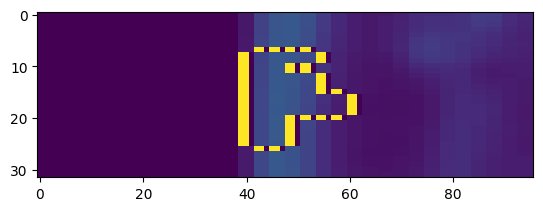

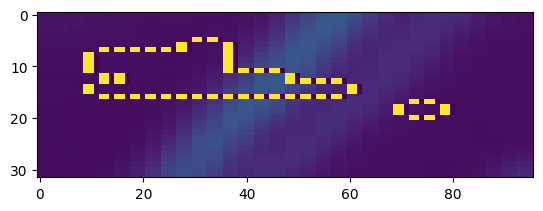

In [21]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
img=masks_with_boundaries(mask_combined_new,initial_masks_new,resized_image_new,128)
# img2 = img[:,:,::-1]
plt.imshow(img)
plt.show()
img=masks_with_boundaries(mask_combined_new,initial_masks_new,resized_image_new,33)
# img2 = img[:,:,::-1]
plt.imshow(img)

In [9]:
filter_mask_of_intrest(mask_combined_new[0,1,:,:,:],initial_masks_new[0,1,:])
(losses[0,:]==jnp.max(losses[0,:])).nonzero()#128
(losses[0,:]==jnp.min(losses[0,:])).nonzero()#0,  1, 15, 16

(Array([ 0,  1, 15, 16], dtype=int32),)

In [ ]:
plt.set_cmap("gray")
plt.imshow(mask_combined_new[0,1:,:,1])
plt.show()

In [2]:
with jax.profiler.trace("/workspaces/Jax_cuda_med/data/profiler_data", create_perfetto_link=True):
  x = random.uniform(random.PRNGKey(0), (100, 100))
  jnp.dot(x, x).block_until_ready() 


: 

: 